In [2]:
import pandas as pd
import numpy as np


MIMIC_DIR = "C:\\Users\\amits\\work\\datasets\\MIMIC-III-v1.4"

patients = pd.read_csv(f"{MIMIC_DIR}\\PATIENTS.csv.gz")
admissions = pd.read_csv(f"{MIMIC_DIR}\\ADMISSIONS.csv.gz",  parse_dates=['ADMITTIME'])
diagnoses_icd = pd.read_csv(f"{MIMIC_DIR}\\DIAGNOSES_ICD.csv.gz")
icustays = pd.read_csv(f"{MIMIC_DIR}\\ICUSTAYS.csv.gz")

micro = pd.read_csv(f"{MIMIC_DIR}\\MICROBIOLOGYEVENTS.csv.gz", parse_dates=['CHARTDATE'], low_memory=False) 
prescriptions = pd.read_csv(f"{MIMIC_DIR}\\PRESCRIPTIONS.csv.gz", parse_dates=['STARTDATE'], low_memory=False)


chartevents = pd.read_csv(f"{MIMIC_DIR}\\CHARTEVENTS.csv.gz", 
                          usecols=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'ITEMID', 'VALUENUM'],
                          chunksize=1000000,
                          low_memory=False, 
                          parse_dates=['CHARTTIME']
             ) # 330712483 rows
labevents = pd.read_csv(f"{MIMIC_DIR}\\LABEVENTS.csv.gz", 
                          usecols=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'ITEMID', 'VALUENUM'],
                          chunksize=1000000, 
                          low_memory=False, 
                          parse_dates=['CHARTTIME']
             ) #27854055 rows

d_items = pd.read_csv(f"{MIMIC_DIR}\\D_ITEMS.csv.gz", 
                          low_memory=False
             )

# https://mimic.mit.edu/docs/iii/tables/inputevents_cv/

# for the following two tables, use inputevents_cvs if you have memory < 32 GB
# I have taken a shortcut by reading the entire thing into memory
usecols_cv = ['SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'STORETIME', 'ITEMID', 'RATE']
inputevents_cv = pd.read_csv(f"{MIMIC_DIR}\\INPUTEVENTS_CV.csv.gz",
                          usecols=usecols_cv,
                          low_memory=False,
                          parse_dates=['CHARTTIME', 'STORETIME']
             )
usecols_mv = [
    'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID',
    'STARTTIME', 'ENDTIME', 'ITEMID',
    'RATE', 'RATEUOM', 'STORETIME'
]

inputevents_mv = pd.read_csv(f"{MIMIC_DIR}\\INPUTEVENTS_MV.csv.gz",
                          low_memory=False,
                          usecols=usecols_mv,
                          parse_dates=['STARTTIME', 'ENDTIME', 'STORETIME']
)

In [3]:
inputevents_cv.head()

,SUBJECT_ID,HADM_ID,CHARTTIME,ITEMID,RATE,STORETIME
0,24457,184834.0,2193-09-11 09:00:00,30056,NaN,2193-09-11 11:12:00
1,24457,184834.0,2193-09-11 12:00:00,30056,NaN,2193-09-11 12:05:00
2,24457,184834.0,2193-09-11 16:00:00,30056,NaN,2193-09-11 16:52:00
3,24457,184834.0,2193-09-11 19:00:00,30056,NaN,2193-09-11 19:06:00
4,24457,184834.0,2193-09-11 21:00:00,30056,NaN,2193-09-11 21:19:00


In [4]:
# https://mimic.mit.edu/docs/iii/tables/inputevents_mv/
# patient weight kgs
inputevents_mv.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,RATE,RATEUOM,STORETIME,PATIENTWEIGHT
0,27063,139787,223259.0,2133-02-05 06:29:00,2133-02-05 08:45:00,225166,NaN,NaN,2133-02-05 06:27:00,83.2
1,27063,139787,223259.0,2133-02-05 05:34:00,2133-02-05 06:30:00,225944,30.142497,mL/hour,2133-02-05 12:57:00,83.2
2,27063,139787,223259.0,2133-02-05 05:34:00,2133-02-05 06:30:00,225166,NaN,NaN,2133-02-05 12:57:00,83.2
3,27063,139787,223259.0,2133-02-03 12:00:00,2133-02-03 12:01:00,225893,NaN,NaN,2133-02-03 13:21:00,83.2
4,27063,139787,223259.0,2133-02-03 12:00:00,2133-02-03 12:01:00,220949,NaN,NaN,2133-02-03 13:21:00,83.2


## Vasopressor data - Metavision and carevue

The MIMIC-III dataset contains data from metavision and carevue.


### Data from carevue 

Using [the answer from the MIMIC team](https://github.com/MIT-LCP/mimic-code/issues/162), we extract:

1. Dopamine data
2. Dobutimine data
3. Epinephrine data
4. Neroepinephrine data

In [5]:
# Patient weights will be used to calculate the rate /kg/microg/min
weight_item_ids = [763, 224639, 226512, 226531]
d_items[d_items['ITEMID'].isin(weight_item_ids)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
1507,688,763,Daily Weight,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
11319,13420,224639,Daily Weight,Daily Weight,metavision,chartevents,General,kg,Numeric,NaN
11875,14391,226512,Admission Weight (Kg),Admission Weight (Kg),metavision,chartevents,General,kg,Numeric,NaN
11885,14401,226531,Admission Weight (lbs.),Admission Weight (lbs.),metavision,chartevents,General,NaN,Numeric,NaN


In [6]:
# Dopamine
cv_dopamine_item_ids = [
    30043, 30307
]
d_items[d_items['ITEMID'].isin(cv_dopamine_item_ids)]



,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
4901,5106,30043,Dopamine,NaN,carevue,inputevents_cv,NaN,NaN,NaN,NaN
5681,5225,30307,Dopamine Drip,NaN,carevue,inputevents_cv,NaN,NaN,NaN,NaN


In [7]:
# Dobutamine
cv_dobutamine_item_ids = [
    30042,30306
]

d_items[d_items['ITEMID'].isin(cv_dobutamine_item_ids)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
5680,5224,30306,Dobutamine Drip,NaN,carevue,inputevents_cv,NaN,NaN,NaN,NaN
5791,5364,30042,Dobutamine,NaN,carevue,inputevents_cv,NaN,NaN,NaN,NaN


In [8]:
# Epinephrine
cv_epinephrine_item_ids = [
    30044, 30119, 30309
]

d_items[d_items['ITEMID'].isin(cv_epinephrine_item_ids)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
4442,5133,30119,Epinephrine-k,NaN,carevue,inputevents_cv,NaN,NaN,NaN,NaN
5683,5227,30309,Epinephrine Drip,NaN,carevue,inputevents_cv,NaN,NaN,NaN,NaN
5792,5365,30044,Epinephrine,NaN,carevue,inputevents_cv,NaN,NaN,NaN,NaN


In [9]:
# Norepinephrine
cv_norepinephrine_item_ids = [
    30047, 30120
]

d_items[d_items['ITEMID'].isin(cv_norepinephrine_item_ids)]
# https://www.rxlist.com/levophed-drug.htm

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
5794,5367,30047,Levophed,NaN,carevue,inputevents_cv,NaN,NaN,NaN,NaN
5839,5414,30120,Levophed-k,NaN,carevue,inputevents_cv,NaN,NaN,NaN,NaN


In [10]:
inputevents_cv[inputevents_cv['ITEMID'].isin(cv_dobutamine_item_ids)]

,SUBJECT_ID,HADM_ID,CHARTTIME,ITEMID,RATE,STORETIME
8676833,1394,164187.0,2104-01-08 04:00:00,30042,NaN,2104-01-08 04:49:00
8676980,4967,110168.0,2180-12-10 06:00:00,30042,NaN,2180-12-10 06:21:00
8678068,4587,167141.0,2149-12-06 02:00:00,30042,NaN,2149-12-06 02:22:00
8678120,6191,169200.0,2144-12-29 22:00:00,30042,NaN,2144-12-29 23:34:00
8678153,1394,164187.0,2104-01-08 15:00:00,30042,NaN,2104-01-08 15:22:00
...,...,...,...,...,...,...
17525812,32135,153608.0,2162-09-10 10:00:00,30042,3.984941,2162-09-10 11:18:00
17525819,32135,153608.0,2162-09-10 11:00:00,30042,3.984941,2162-09-10 11:20:00
17525826,32135,153608.0,2162-09-10 12:00:00,30042,3.984941,2162-09-10 14:46:00
17526379,32135,153608.0,2162-09-08 19:00:00,30042,3.984941,2162-09-08 19:00:00


In [11]:
cv_dopam_df = inputevents_cv[inputevents_cv['ITEMID'].isin(cv_dopamine_item_ids)]
cv_dobatumine_df = inputevents_cv[inputevents_cv['ITEMID'].isin(cv_dobutamine_item_ids)]
cv_epinephrine_df = inputevents_cv[inputevents_cv['ITEMID'].isin(cv_epinephrine_item_ids)]
cv_norepinenephrine_df = inputevents_cv[inputevents_cv['ITEMID'].isin(cv_norepinephrine_item_ids)]

In [12]:
cv_dopam_df

,SUBJECT_ID,HADM_ID,CHARTTIME,ITEMID,RATE,STORETIME
8676800,7605,107327.0,2147-01-19 17:00:00,30043,NaN,2147-01-19 17:12:00
8676853,590,172260.0,2124-11-14 04:00:00,30043,NaN,2124-11-14 04:19:00
8676854,12744,116766.0,2166-12-09 04:00:00,30043,NaN,2166-12-09 04:18:00
8676855,2128,152495.0,2166-11-25 04:00:00,30043,NaN,2166-11-25 04:44:00
8676856,20866,147338.0,2198-12-25 04:00:00,30043,NaN,2198-12-25 04:46:00
...,...,...,...,...,...,...
17525789,29601,188620.0,2135-09-16 10:00:00,30043,5.0,2135-09-16 10:05:00
17525830,30286,193809.0,2181-08-19 02:00:00,30043,8.0,2181-08-19 01:33:00
17525837,30286,193809.0,2181-08-19 03:00:00,30043,8.0,2181-08-19 04:02:00
17525848,30286,193809.0,2181-08-19 04:00:00,30043,8.0,2181-08-19 04:02:00


In [13]:
cv_dobatumine_df

,SUBJECT_ID,HADM_ID,CHARTTIME,ITEMID,RATE,STORETIME
8676833,1394,164187.0,2104-01-08 04:00:00,30042,NaN,2104-01-08 04:49:00
8676980,4967,110168.0,2180-12-10 06:00:00,30042,NaN,2180-12-10 06:21:00
8678068,4587,167141.0,2149-12-06 02:00:00,30042,NaN,2149-12-06 02:22:00
8678120,6191,169200.0,2144-12-29 22:00:00,30042,NaN,2144-12-29 23:34:00
8678153,1394,164187.0,2104-01-08 15:00:00,30042,NaN,2104-01-08 15:22:00
...,...,...,...,...,...,...
17525812,32135,153608.0,2162-09-10 10:00:00,30042,3.984941,2162-09-10 11:18:00
17525819,32135,153608.0,2162-09-10 11:00:00,30042,3.984941,2162-09-10 11:20:00
17525826,32135,153608.0,2162-09-10 12:00:00,30042,3.984941,2162-09-10 14:46:00
17526379,32135,153608.0,2162-09-08 19:00:00,30042,3.984941,2162-09-08 19:00:00


In [14]:
cv_epinephrine_df

,SUBJECT_ID,HADM_ID,CHARTTIME,ITEMID,RATE,STORETIME
8682945,6104,167627.0,2190-12-02 19:00:00,30119,NaN,2190-12-02 19:27:00
8687458,1394,164187.0,2104-01-05 10:00:00,30119,NaN,2104-01-05 11:03:00
8687517,15276,138479.0,2121-01-23 02:00:00,30119,NaN,2121-01-23 02:06:00
8687651,20241,118071.0,2200-12-10 06:00:00,30119,NaN,2200-12-10 06:25:00
8687680,20241,118071.0,2200-12-10 07:00:00,30119,NaN,2200-12-10 07:33:00
...,...,...,...,...,...,...
17526070,30376,185179.0,2169-07-27 05:30:00,30119,0.03,2169-07-27 05:38:00
17527374,30376,185179.0,2169-07-27 02:00:00,30119,0.03,2169-07-27 02:06:00
17527377,32135,NaN,2162-08-19 02:00:00,30119,0.03,2162-08-19 02:07:00
17527400,30376,185179.0,2169-07-27 02:15:00,30119,0.03,2169-07-27 02:09:00


In [15]:
cv_norepinenephrine_df

,SUBJECT_ID,HADM_ID,CHARTTIME,ITEMID,RATE,STORETIME
8676814,14076,146527.0,2146-01-14 03:00:00,30120,NaN,2146-01-14 03:08:00
8676819,2103,158138.0,2177-01-03 03:00:00,30120,NaN,2177-01-03 03:11:00
8676831,590,172260.0,2124-11-14 04:00:00,30047,NaN,2124-11-14 04:19:00
8676832,17680,114829.0,2107-01-18 04:00:00,30047,NaN,2107-01-18 03:56:00
8676879,16881,171788.0,2164-12-29 10:30:00,30047,NaN,2164-12-29 10:23:00
...,...,...,...,...,...,...
17526069,27120,180728.0,2178-08-06 05:30:00,30120,0.04,2178-08-06 05:50:00
17527231,31454,117800.0,2143-08-21 16:00:00,30120,0.12,2143-08-21 15:55:00
17527413,32505,198103.0,2154-09-28 05:45:00,30120,0.05,2154-09-28 06:08:00
17527428,32505,198103.0,2154-09-28 06:00:00,30120,0.05,2154-09-28 06:08:00


In [55]:
for df, name in [
    (cv_norepinenephrine_df, 'norepinephrine'),
    (cv_epinephrine_df, 'epinephrine'),
    (cv_dopam_df, 'dopamine'),
    (cv_dobatumine_df, 'dobutamine')
]:
    df['drug'] = name

vaso_cv = pd.concat([cv_dopam_df, cv_dobatumine_df, cv_epinephrine_df, cv_norepinenephrine_df], ignore_index=True)
vaso_cv.head()

C:\Users\amits\AppData\Local\Temp\ipykernel_17072\591469041.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['drug'] = name


,SUBJECT_ID,HADM_ID,CHARTTIME,ITEMID,RATE,STORETIME,drug
0,7605,107327.0,2147-01-19 17:00:00,30043,NaN,2147-01-19 17:12:00,dopamine
1,590,172260.0,2124-11-14 04:00:00,30043,NaN,2124-11-14 04:19:00,dopamine
2,12744,116766.0,2166-12-09 04:00:00,30043,NaN,2166-12-09 04:18:00,dopamine
3,2128,152495.0,2166-11-25 04:00:00,30043,NaN,2166-11-25 04:44:00,dopamine
4,20866,147338.0,2198-12-25 04:00:00,30043,NaN,2198-12-25 04:46:00,dopamine


In [17]:
weights_rows = []

for chunk in chartevents:
    chunk_weight = chunk[chunk['ITEMID'].isin(weight_item_ids)].dropna(subset=['VALUENUM'])
    weights_rows.append(chunk_weight)


In [34]:
weights_df = pd.concat(weights_rows)

# # Take the first weight measurement per hadm_id
weights = weights_df.sort_values(
    ['HADM_ID', 'CHARTTIME']
).groupby('HADM_ID').first()

weights = weights.rename(columns={'VALUENUM': 'WEIGHT'})
#weights
weights = weights[['WEIGHT']]
weights

,WEIGHT
HADM_ID,
100001,217.800000
100003,187.700000
100006,57.000000
100007,55.099998
100009,115.000000
...,...
199992,117.500000
199993,67.300003
199994,118.500000


In [56]:
vaso_cv = vaso_cv.merge(weights, on='HADM_ID', how='left')

# https://github.com/MIT-LCP/mimic-code/issues/162#issuecomment-269839918
ug_min_itemids = [30047, 30044] 

vaso_cv['rate_ugkgmin'] = np.where(
    vaso_cv['ITEMID'].isin(ug_min_itemids),
    vaso_cv['RATE'] / vaso_cv['WEIGHT'],
    vaso_cv['RATE']
)

In [40]:
vaso_cv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857867 entries, 0 to 857866
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   SUBJECT_ID    857867 non-null  int64         
 1   HADM_ID       855883 non-null  float64       
 2   CHARTTIME     857867 non-null  datetime64[ns]
 3   ITEMID        857867 non-null  int64         
 4   RATE          518388 non-null  float64       
 5   STORETIME     857867 non-null  datetime64[ns]
 6   drug          857867 non-null  object        
 7   WEIGHT        749894 non-null  float64       
 8   rate_ugkgmin  452127 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 58.9+ MB


### Sanity checking

In [57]:
for item in vaso_cv.groupby(['drug']):
    print(item[1]['rate_ugkgmin'].value_counts(normalize=True))
    print(item[1]['RATE'].value_counts(normalize=True))
        

rate_ugkgmin
5.000000     0.208681
2.500000     0.134815
2.000000     0.077911
3.000000     0.076887
0.000000     0.072355
               ...   
5.400000     0.000024
3.658536     0.000024
6.583333     0.000024
50.000000    0.000024
11.500000    0.000024
Name: proportion, Length: 432, dtype: float64
RATE
5.000000     0.208681
2.500000     0.134815
2.000000     0.077911
3.000000     0.076887
0.000000     0.072355
               ...   
5.400000     0.000024
3.658536     0.000024
6.583333     0.000024
50.000000    0.000024
11.500000    0.000024
Name: proportion, Length: 432, dtype: float64
rate_ugkgmin
5.000000     0.110653
3.000000     0.109859
2.000000     0.099434
0.000000     0.093515
10.000000    0.060860
               ...   
5.436692     0.000008
2.005168     0.000008
9.756098     0.000008
10.037037    0.000008
5.048544     0.000008
Name: proportion, Length: 2551, dtype: float64
RATE
5.000000     0.110653
3.000000     0.109859
2.000000     0.099434
0.000000     0.093515
10.000000  

In [58]:
for item in vaso_cv.groupby(['drug']):
    print(item[0], item[1]['rate_ugkgmin'].describe(percentiles=[0.5,0.9,0.99]))

('dobutamine',) count    41034.000000
mean         4.644454
std          3.934591
min          0.000000
50%          4.000000
90%         10.000000
99%         20.000000
max         50.000000
Name: rate_ugkgmin, dtype: float64
('dopamine',) count    124696.000000
mean          6.062448
std           5.512145
min           0.000000
50%           5.000000
90%          14.000000
99%          25.000000
max          74.074074
Name: rate_ugkgmin, dtype: float64
('epinephrine',) count    50529.000000
mean         0.043443
std          0.143705
min          0.000000
50%          0.020000
90%          0.070000
99%          0.400000
max          8.000000
Name: rate_ugkgmin, dtype: float64
('norepinephrine',) count    300661.000000
mean          0.140759
std           0.338586
min           0.000000
50%           0.080000
90%           0.300000
99%           0.900000
max          50.000000
Name: rate_ugkgmin, dtype: float64


In [60]:
vaso_cv.groupby('drug')['HADM_ID'].nunique()
vaso_cv['drug'].value_counts(normalize=True)*100


drug
norepinephrine    58.195851
dopamine          24.096509
epinephrine        9.729946
dobutamine         7.977694
Name: proportion, dtype: float64

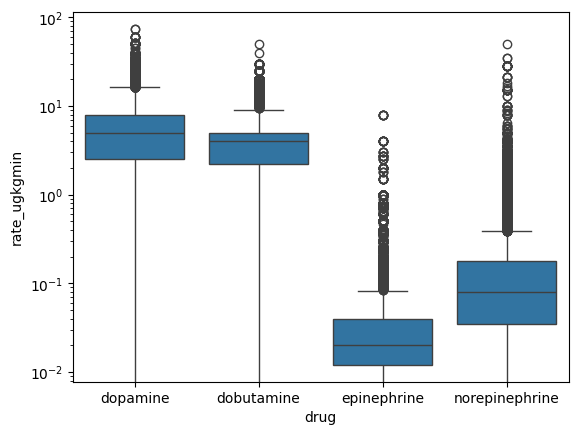

In [61]:
import seaborn as sns, matplotlib.pyplot as plt
sns.boxplot(data=vaso_cv, x='drug', y='rate_ugkgmin')
plt.yscale('log')
plt.show()

### Data from metavision

[Reference for item ids](https://github.com/MIT-LCP/mimic-code/blob/57069783095e7770e66ea97da264c0200078ddbf/mimic-iii/concepts/durations/vasopressor_durations.sql)

As for carevue, we extract:

1. Dopamine data
2. Dobutimine data
3. Epinephrine data
4. Neroepinephrine data

In [63]:
# Dopamine
mv_dopamine_item_ids = [
    221662
]
d_items[d_items['ITEMID'].isin(mv_dopamine_item_ids)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
8891,12972,221662,Dopamine,Dopamine,metavision,inputevents_mv,Medications,mg,Solution,NaN


In [67]:
# Dobutamine
mv_dobutamine_item_ids = [
    221653
]
d_items[d_items['ITEMID'].isin(mv_dobutamine_item_ids)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
8890,12971,221653,Dobutamine,Dobutamine,metavision,inputevents_mv,Medications,mg,Solution,NaN


In [69]:
# epinephrine
mv_epinephrine_item_ids = [
    221289
]
d_items[d_items['ITEMID'].isin(mv_epinephrine_item_ids)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
8879,12960,221289,Epinephrine,Epinephrine,metavision,inputevents_mv,Medications,mg,Solution,NaN


In [70]:
# norepinephrine
mv_norepinephrine_item_ids = [
    221906
]
d_items[d_items['ITEMID'].isin(mv_norepinephrine_item_ids)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
9553,12984,221906,Norepinephrine,Norepinephrine,metavision,inputevents_mv,Medications,mg,Solution,NaN


In [71]:
vaso_itemids_mv = {
    'norepinephrine': [221906],
    'epinephrine': [221289],
    'dopamine': [221662],
    'dobutamine': [221653],
}
mv_ids = [i for ids in vaso_itemids_mv.values() for i in ids]
vaso_mv = inputevents_mv[inputevents_mv['ITEMID'].isin(mv_ids)].copy()


In [72]:
vaso_mv
# mcg is the same as microgram/kg/min (RATEUOM)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,RATE,RATEUOM,STORETIME,PATIENTWEIGHT
170,27063,139787,223259.0,2133-02-04 14:53:00,2133-02-04 14:54:00,221906,0.100056,mcg/kg/min,2133-02-04 14:53:00,83.2
646,29056,163573,228281.0,2124-03-01 23:29:00,2124-03-02 20:57:00,221906,0.100019,mcg/kg/min,2124-03-01 23:29:00,62.1
652,29056,163573,228281.0,2124-03-01 20:43:00,2124-03-01 22:51:00,221906,0.113476,mcg/kg/min,2124-03-02 00:44:00,62.1
663,29056,163573,228281.0,2124-03-02 09:30:00,2124-03-02 20:40:00,221906,0.100260,mcg/kg/min,2124-03-02 10:19:00,62.1
667,29056,163573,228281.0,2124-03-02 10:20:00,2124-03-02 17:45:00,221906,0.079967,mcg/kg/min,2124-03-02 10:20:00,62.1
...,...,...,...,...,...,...,...,...,...,...
3618846,5171,125124,222399.0,2171-10-16 14:29:00,2171-10-16 14:33:00,221906,0.040044,mcg/kg/min,2171-10-16 14:30:00,73.0
3618852,55781,186666,208138.0,2193-09-08 09:19:00,2193-09-08 09:20:00,221906,0.401884,mcg/kg/min,2193-09-08 09:15:00,91.0
3618867,55781,186666,208138.0,2193-08-30 17:02:00,2193-08-30 23:47:00,221653,5.004103,mcg/kg/min,2193-08-31 00:28:00,91.0
3618870,55781,186666,208138.0,2193-09-03 09:04:00,2193-09-03 09:08:00,221906,0.255495,mcg/kg/min,2193-09-03 09:35:00,91.0


In [73]:
drug_map_mv = {itemid: drug for drug, ids in vaso_itemids_mv.items() for itemid in ids}
vaso_mv['drug'] = vaso_mv['ITEMID'].map(drug_map_mv)

In [74]:
vaso_mv['RATEUOM'].value_counts(dropna=False)

RATEUOM
mcg/kg/min    109732
Name: count, dtype: int64

In [76]:
vaso_mv['rate_ugkgmin'] = vaso_mv['RATE']

In [77]:
vaso_mv = vaso_mv.rename(columns={'STARTTIME': 'CHARTTIME'})
vaso_mv['SOURCE'] = 'MetaVision'
vaso_mv = vaso_mv[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID',
                   'CHARTTIME', 'ITEMID', 'rate_ugkgmin', 'drug', 'SOURCE']]

In [78]:
vaso_mv['drug'].value_counts(normalize=True) * 100

drug
norepinephrine    81.741880
dopamine          10.378923
epinephrine        5.844239
dobutamine         2.034958
Name: proportion, dtype: float64

In [86]:
vaso_mv.shape

(109732, 8)

In [94]:
for item in vaso_mv.groupby(['drug']):
    print(item[0], item[1]['rate_ugkgmin'].describe(percentiles=[0.5,0.9,0.99]))

('dobutamine',) count    2233.000000
mean        5.426870
std        10.719237
min         0.080024
50%         4.935735
90%         9.999227
99%        20.024356
max       260.476217
Name: rate_ugkgmin, dtype: float64
('dopamine',) count    11389.000000
mean         9.632002
std         69.866482
min          0.250009
50%          6.021785
90%         15.069323
99%         20.525554
max       4000.000100
Name: rate_ugkgmin, dtype: float64
('epinephrine',) count    6413.000000
mean        0.079927
std         0.416564
min         0.000801
50%         0.039869
90%         0.139951
99%         0.517213
max        23.271080
Name: rate_ugkgmin, dtype: float64
('norepinephrine',) count    89697.000000
mean         0.203863
std          1.765823
min          0.000200
50%          0.110528
90%          0.378798
99%          0.801001
max        359.550584
Name: rate_ugkgmin, dtype: float64


## Combining the two data sources

In [96]:
vaso_cv['SOURCE'] = 'CareVue'
vaso_mv['SOURCE'] = 'MetaVision'

In [97]:
vaso_cv.shape

(857867, 10)

In [98]:
vaso_mv.shape

(109732, 9)

In [99]:
vaso_all = pd.concat([vaso_cv, vaso_mv], ignore_index=True)
vaso_all["SOURCE"].value_counts(normalize=True)

SOURCE
CareVue       0.886594
MetaVision    0.113406
Name: proportion, dtype: float64

In [102]:
vaso_all.groupby(['SOURCE', 'drug'])['rate_ugkgmin'].describe(percentiles=[0.5,0.9,0.99])

count      mean        std       min       50%  \
SOURCE     drug                                                                
CareVue    dobutamine       41034.0  4.644454   3.934591  0.000000  4.000000   
           dopamine        124696.0  6.062448   5.512145  0.000000  5.000000   
           epinephrine      50529.0  0.043443   0.143705  0.000000  0.020000   
           norepinephrine  300661.0  0.140759   0.338586  0.000000  0.080000   
MetaVision dobutamine        2233.0  5.426870  10.719237  0.080024  4.935735   
           dopamine         11389.0  9.632002  69.866482  0.250009  6.021785   
           epinephrine       6413.0  0.079927   0.416564  0.000801  0.039869   
           norepinephrine   89697.0  0.203863   1.765823  0.000200  0.110528   

                                 90%        99%          max  
SOURCE     drug                                               
CareVue    dobutamine      10.000000  20.000000    50.000000  
           dopamine        14.000000  25.000000    74.074074  
           epinephrine      0.070000   0.400000     8.000000  
           norepinephrine   0.300000   0.900000    50.000000  
MetaVision dobutamine       9.999227  20.024356   260.476217  
           dopamine        15.069323  20.525554  4000.000100  
           epinephrine      0.139951   0.517213    23.271080  
           norepinephrine   0.378798   0.801001   359.550584

In [103]:
vaso_all['rate_ugkgmin_clipped'] = vaso_all.apply(
    lambda row: (
        min(row['rate_ugkgmin'], 5) if row['drug'] in ['norepinephrine', 'epinephrine']
        else min(row['rate_ugkgmin'], 30)
    ),
    axis=1
)


In [104]:
vaso_all.groupby(['SOURCE', 'drug'])['rate_ugkgmin_clipped'].describe(percentiles=[0.5,0.9,0.99])

count      mean       std       min       50%  \
SOURCE     drug                                                               
CareVue    dobutamine       41034.0  4.643723  3.928326  0.000000  4.000000   
           dopamine        124696.0  6.051182  5.445838  0.000000  5.000000   
           epinephrine      50529.0  0.043087  0.126692  0.000000  0.020000   
           norepinephrine  300661.0  0.138517  0.221786  0.000000  0.080000   
MetaVision dobutamine        2233.0  5.022576  3.737609  0.080024  4.935735   
           dopamine         11389.0  7.816453  5.269636  0.250009  6.021785   
           epinephrine       6413.0  0.074857  0.199729  0.000801  0.039869   
           norepinephrine   89697.0  0.179408  0.294501  0.000200  0.110528   

                                 90%        99%   max  
SOURCE     drug                                        
CareVue    dobutamine      10.000000  20.000000  30.0  
           dopamine        14.000000  25.000000  30.0  
           epinephrine      0.070000   0.400000   5.0  
           norepinephrine   0.300000   0.900000   5.0  
MetaVision dobutamine       9.999227  20.024356  30.0  
           dopamine        15.069323  20.525554  30.0  
           epinephrine      0.139951   0.517213   5.0  
           norepinephrine   0.378798   0.801001   5.0

In [105]:
vaso_summary = (
    vaso_all
    .groupby(['HADM_ID', 'drug'], as_index=False)
    .agg(max_rate=('rate_ugkgmin_clipped', 'max'))
)


In [107]:
vaso_summary

,HADM_ID,drug,max_rate
0,100003.0,dopamine,12.013675
1,100003.0,norepinephrine,0.100092
2,100038.0,dopamine,2.472406
3,100053.0,norepinephrine,0.600000
4,100061.0,dobutamine,2.501150
...,...,...,...
13949,199992.0,dopamine,2.000170
13950,199993.0,dopamine,10.000000
13951,199993.0,epinephrine,0.300000
13952,199993.0,norepinephrine,0.250000


In [113]:
vaso_pivot = (
    vaso_summary
    .pivot_table(index='HADM_ID', columns='drug', values='max_rate', aggfunc='max')
    .fillna(0)
    .reset_index()
)
vaso_pivot.columns
vaso_pivot.columns.name = None  # remove 'drug' header label if present
vaso_pivot

,HADM_ID,dobutamine,dopamine,epinephrine,norepinephrine
0,100003.0,0.00000,12.013675,0.000000,0.100092
1,100038.0,0.00000,2.472406,0.000000,0.000000
2,100053.0,0.00000,0.000000,0.000000,0.600000
3,100061.0,2.50115,24.822132,0.140292,0.622032
4,100068.0,0.00000,0.000000,0.080065,0.000000
...,...,...,...,...,...
10499,199969.0,3.50000,0.000000,0.000000,0.000000
10500,199972.0,0.00000,0.000000,0.020004,0.000000
10501,199992.0,0.00000,2.000170,0.000000,0.000000
10502,199993.0,0.00000,10.000000,0.300000,0.250000


## Mean arterial pressure

In [120]:
map_itemids = [52, 6702, 443, 220052, 220181]
d_items[d_items['ITEMID'].isin(map_itemids)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
321,58,52,Arterial BP Mean,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
672,409,443,Manual BP Mean(calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
5063,4326,6702,Arterial BP Mean #2,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
11504,12718,220052,Arterial Blood Pressure mean,ABPm,metavision,chartevents,Routine Vital Signs,mmHg,Numeric,NaN
11522,12736,220181,Non Invasive Blood Pressure mean,NBPm,metavision,chartevents,Routine Vital Signs,mmHg,Numeric,NaN


In [122]:
usecols = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME', 'VALUENUM']

chunks = []
for chunk in pd.read_csv(
    f"{MIMIC_DIR}/CHARTEVENTS.csv.gz",
    usecols=usecols,
    chunksize=1_000_000,
    low_memory=False,
    parse_dates=['CHARTTIME']
):
    filtered = chunk[chunk['ITEMID'].isin(map_itemids)]
    chunks.append(filtered)

map_df = pd.concat(chunks, ignore_index=True)
map_df.rename(columns={'VALUENUM': 'MAP'}, inplace=True)

In [123]:
map_df

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,MAP
0,36,165660,241249.0,220181,2134-05-12 13:00:00,84.0
1,36,165660,241249.0,220181,2134-05-12 14:00:00,65.0
2,36,165660,241249.0,220181,2134-05-12 15:00:00,79.0
3,36,165660,241249.0,220181,2134-05-12 16:00:00,85.0
4,34,144319,290505.0,220181,2191-02-23 05:30:00,78.0
...,...,...,...,...,...,...
4543051,32786,165351,275017.0,52,2152-11-16 15:00:00,67.0
4543052,32775,128184,292368.0,52,2200-09-02 02:00:00,81.0
4543053,32775,128184,292368.0,52,2200-09-02 22:00:00,99.0
4543054,32777,105007,202322.0,52,2113-10-12 12:15:00,69.0


In [125]:
map_df["MAP"].min(), map_df["MAP"].max()

(np.float64(-135.0), np.float64(120130.03))

In [126]:
map_df = map_df[(map_df['MAP'] >= 20) & (map_df['MAP'] <= 180)]

In [166]:
map_min = (
    map_df.groupby('HADM_ID', as_index=False)[['MAP', 'CHARTTIME']]
          .min()
          .rename(columns={'MAP': 'MAP_min'})
)

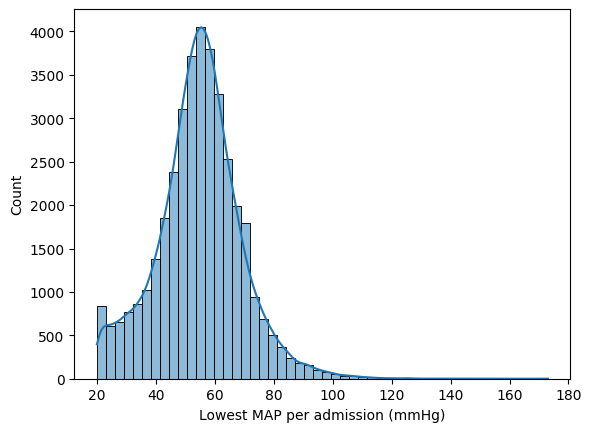

In [167]:
import seaborn as sns, matplotlib.pyplot as plt
sns.histplot(map_min['MAP_min'], bins=50, kde=True)
plt.xlabel('Lowest MAP per admission (mmHg)')
plt.show()


## Calculating SOFA score

In [168]:
def sofa_cv(row):
    # print(row)
    norepi = row.get('norepinephrine', 0)
    epi = row.get('epinephrine', 0)
    dopa = row.get('dopamine', 0)
    dob = row.get('dobutamine', 0)
    map_val = row.get('MAP_min', 0)
   
    # SOFA cardiovascular logic (Sepsis-3 definition)
    if map_val < 70:
        return 1
    elif (dopa <= 5) or (dob > 0):
        return 2
    elif (norepi <= 0.1) or (epi <= 0.1) or (dopa > 5):
        return 3
    elif (norepi > 0.1) or (epi > 0.1) or (dopa > 15):
        return 4
    else:
        return 0


In [169]:
sofa_input = vaso_pivot.merge(map_min, on='HADM_ID', how='left')
sofa_input['MAP_min'] = sofa_input['MAP_min'].fillna(0)

In [170]:
sofa_input['SOFA_CV'] = sofa_input.apply(sofa_cv, axis=1)

In [171]:
sofa_input['SOFA_CV'].value_counts(normalize=True) * 100

SOFA_CV
1    98.029322
2     1.542270
3     0.428408
Name: proportion, dtype: float64

In [172]:
(vaso_pivot[['norepinephrine','epinephrine','dopamine','dobutamine']] > 0).any(axis=1).mean()*100

np.float64(99.60967250571211)

In [173]:
sofa_input

,HADM_ID,dobutamine,dopamine,epinephrine,norepinephrine,MAP,SOFA_CV,MAP_min,CHARTTIME
0,100003.0,0.00000,12.013675,0.000000,0.100092,0,1,47.0,2150-04-17 17:00:00
1,100038.0,0.00000,2.472406,0.000000,0.000000,0,1,0.0,NaT
2,100053.0,0.00000,0.000000,0.000000,0.600000,0,1,26.0,2124-07-17 15:20:00
3,100061.0,2.50115,24.822132,0.140292,0.622032,0,1,23.0,2178-12-25 14:30:00
4,100068.0,0.00000,0.000000,0.080065,0.000000,0,1,54.0,2192-01-13 16:39:00
...,...,...,...,...,...,...,...,...,...
10499,199969.0,3.50000,0.000000,0.000000,0.000000,0,1,49.0,2201-01-27 19:55:00
10500,199972.0,0.00000,0.000000,0.020004,0.000000,0,1,47.0,2186-08-29 13:18:00
10501,199992.0,0.00000,2.000170,0.000000,0.000000,0,1,51.0,2155-02-11 17:21:00
10502,199993.0,0.00000,10.000000,0.300000,0.250000,0,1,55.0,2161-10-23 22:00:00
